# Structural Causal Models

This notebook is used to introduce the generic SCM generators where we can use to produce simulated DAGs. Since simulated DAGs can have a variaty of graph structures as well as a veriety of functional assumptions, this notebook uses SCM generators to obtain any sort of SCM we intend to use for our causal inference or discovery.

In [1]:
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload

## SCM generators

The datamodules can use a certain SCM generator to come up with their SCM model. In this section, we will work with the `SCMGenerator` class to see how they work. Afterward, we can plug this into our datamodule, but for now, learning the generator itself is of importance. Note that the process of SCM generation is decoupled into figuring out the causal graph and then figuring out the functional scheme that governs the SCM. For that reason,

### Graph generation

The `SCMGenerator` class instances get input parameters corresponding to how they generate their graphs. You can set the type of graph produced alongside a set of `graph_generator_args` to define your random graph. The following summarizes current methods:
* `chain`: Creates a random chain.
    * `n`: The number of nodes in the chain
* `collider` or `v_structure`: Creates a random collider.
    * `n`: The number of nodes in the collider.
* `fork`: Creates a random fork.
    * `n`: The number of nodes in the fork.
* `tree` (Still buggy!): Creates a directed tree where everything depends on its immediate successors.
    * `n`: The number of nodes in the tree.
* `full`: Creates a random tournament.
    * `n`: Size of the tournament.
* `erdos_renyi`: Creates a binomial random graph using the Erdos Renyi scheme:
    * `n`: The number of nodes.
    * `p`: resembles the `p` value used in the Erdos Renyi scheme.
* `barabasi_albert`: Creates a random graph using the Barabasi Albert model.
    * `n`: The number of nodes.
    * `m`: The number of edges.
* `random_graph`: Creates a random graph by sampling edges independently with probability `p`.
    * `n`: The number of nodes.
    * `p`: The probability of picking an edge.



In [3]:
# an example of a generation scheme:
graph_generation_scheme = dict(
    graph_generator_type='erdos_renyi',
    graph_generator_args=dict(
        n=5,
        p=0.7
    )
)

### Functional scheme generation

To come up with a very generic functional scheme, we assign parameters to each edge and vertex. These parameters are generated from a controllable dictionary `functional_form_generator_args`. After generating the parameters that define each of the functions, we then define the structural equation functions as follows:
$$x_i = f_(z_i, x(Par(i)); \Theta(i), \Theta(Par(i)_1), ..., \Theta(Par(i)_k))$$
Although you can define this functions purely generic, for simple illustration, we will consider an `AffineAdditiveSCMGenerator` in the following which considers only SCMs that are Affine/Additive. 

For example, in the following we have defined an scm generator using a seed for reproducability and copied the graph generative arguments from last step. For the functions themselves, we have a set of arguments: `function_type`, `noise_type`, `functional_form_generator_args`. The first is a string indicating the type of functions being used in the SCM; for example, when it is set to `linear_additive` this means that the functions are of the following form: $x_i = f_i(Par(i)) = \sum_{j \in Par(i)} x_j w_j + w_i z_i$. The `noise_type` simply states what sort of noise is being used here; for example, setting it to either `laplace` or `gaussian` will show the distribution of the noise being sampled. Finally, `functional_form_generator_args` is a dictionary containing all which is needed to generate the parameters corresponding to the SCM functions.

For example, `linear_additive` models have a set of parameters $w_{ij}$ which is the weight of $x_j$ in the function of $f_i$ and you can sample it from a uniform distribution between `weight_low` and `weight_high`. On the other hand, when you want to sample the noises, these Laplace/Gaussian noises come from distributions parameterized by mean and variance; therefore, we can generate these parameters also from a uniform distribution for each vertex. That said, the following generator will give us a generic additive linear SCM with a random graph and Laplace exogenous noise variables:

In [22]:
%autoreload 2
from ocd.data.affine_additive.scm import AffineAdditiveSCMGenerator

scm_generator = AffineAdditiveSCMGenerator(
    seed=151,
    **graph_generation_scheme,
    function_type='linear_additive',
    noise_type='laplace',
    functional_form_generator_args=dict(
        weight_low=0.2,
        weight_high=1.0,
        noise_std_low=0.2,
        noise_std_high=1.0,
        noise_mean_low=0.2,
        noise_mean_high=1.0
    )
)


You can get a sample from this scm generator using the following piece of code:

In [54]:
scm = scm_generator.generate_scm()

Tou can draw out a summary of the SCM using the `draw` method which will print out a symbolic representation of the SCM functions alongside a networkx plot of the causal graph. For example, run the following code:

x(0) = N(0.93, 0.74)
---------------------

x(2) = N(0.91, 0.73)
---------------------

x(4) = 0.62 . (sigmoid(0.96x(0) + 0.43x(0)^2 + 0.89x(0)^3)) + N(0.83, 0.60)
---------------------

x(3) = 0.57 . (sigmoid(0.84x(0) + 0.41x(0)^2 + 0.64x(0)^3) + sigmoid(0.49x(2) + 0.37x(2)^2 + 0.47x(2)^3)) + N(0.77, 0.27)
---------------------

x(1) = 0.62 . (sigmoid(0.90x(0) + 0.25x(0)^2 + 0.30x(0)^3) + sigmoid(0.86x(2) + 0.91x(2)^2 + 0.91x(2)^3) + sigmoid(0.25x(3) + 0.60x(3)^2 + 0.98x(3)^3)) + N(0.28, 0.65)
---------------------



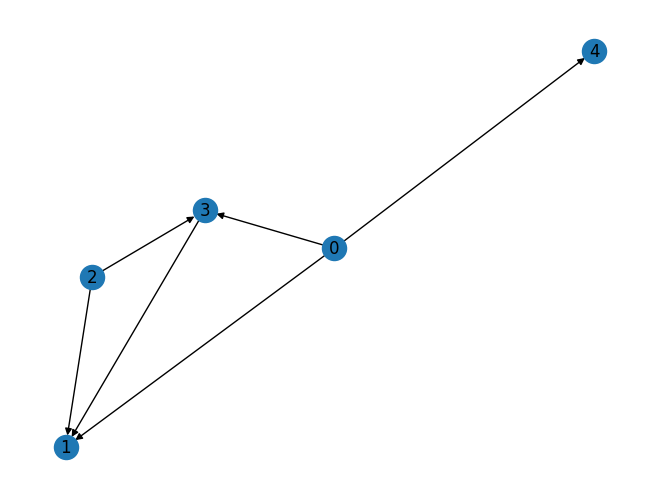

In [55]:
scm.draw(with_labels=False)

### Generic SCMs

Here we will present how to implement an arbitrary SCM generator with arbitrary functional formats. Let's say we want to create SCMs that have the following functional form:
$$x_i = v_i \cdot \left(\sum_{j \in Par_i} \sigma(f_{ij}(x_j))\right) + \mathcal{N}(\mu_i, \sigma_i) \text{ where } f_{ij}(x_j) = w_{ij}^{(1)} x_j + w_{ij}^{(2)} x_j^2 + w_{ij}^{(3)} x_j^3$$
Note that we first generate parameters for each of the edges as well as vertices. Therefore, 
* Parameters corresponding to each vertex $i$ would be $\{v_i\}$
* Parameters corresponding to each edge $ij$ would be $\{w_{ij}^{(1)}, w_{ij}^{(2)}, w_{ij}^{(3)}\}$.

This translates into the two functions below that should all return a dictionary containing parameters corresponding to nodes and edges. Each of these functions also get hyper-parameters `weight_low` and `weight_high` which represent the lower and upper bounds of the uniform distribution where the parameters is going to be drawn from.

In [39]:
import numpy as np

def generate_node_functional_parameters(dag, v, seed, **kwargs):
    np.random.seed(seed)
    return dict(v=np.random.uniform(kwargs['weight_low'], kwargs['weight_high']))

def generate_edge_functional_parameters(dag, v, par, seed, **kwargs):
    np.random.seed(seed)
    return dict(w1=np.random.uniform(kwargs['weight_low'], kwargs['weight_high']),
                w2=np.random.uniform(kwargs['weight_low'], kwargs['weight_high']),
                w3=np.random.uniform(kwargs['weight_low'], kwargs['weight_high']))

   

We should also define functions that generate parameters for the noises.

In [40]:
def generate_noise_functional_parameters(dag, v, seed, **kwargs):
    np.random.seed(seed)
    return dict(var=np.random.uniform(kwargs['noise_variance_low'], kwargs['noise_variance_high']),
                mean=np.random.uniform(kwargs['noise_mean_low'], kwargs['noise_mean_high']))

Now two/three functions remain to be defined for our full SCM to become well-defined. These functions are related to the SCM itself and tries to simulate the data generating process.
* `get_exogenous_noise(seed, **params)`: This function has to have `params` corresponding to the signature of the `generate_noise_functional_parameters` return value. Since we defined it as a dictionary with `var` and `mean` these will be the inputs to this function:

In [41]:

def get_exogenous_noise(seed, var, mean):
    np.random.seed(seed)
    return np.random.normal(mean, var)
    

* `get_covariate_from_parents(inputs, params)`: This is the actual function that is happening in the data generation process of our SCM. `inputs[0]` is always the noise value while `inputs[1..]` are the endogenous variable values of the parents. Furthermore, `params[0]` will represent the parameters corresponding to the current vertex and `params[i]` for $i > 0$ corresponds to the parameters for `input[i]`. For example, here `params[0]` will be a dictionary containing only `v` and `params[i]` will be a dictonary containing all three `w1`, `w2`, and `w3`.

In [47]:
def get_covariate_from_parents(inputs, params):
    sm = 0
    for x, p in zip(inputs[1:], params[1:]):
        t = x * p['w1'] + x**2 * p['w2'] + x**3 * p['w3']
        # take the sigmoid of t
        sm += 1 / (1 + np.exp(-t))
    return params[0]['v'] * sm + inputs[0]

* `get_covariate_from_parents_signature(inputs, params)`: This function is only defined for the `draw` method to work. This will only give you a meta representation of the function. Here, `inputs[i]` represents the $i$th parent label of our current node and `inputs[0]` represents the noise variables of the current node.

In [48]:
def get_covariate_from_parents_signature(inputs, params): 
    all = []
    for x, p in zip(inputs[1:], params[1:]):
        t = f"{p['w1']:.2f}x({x}) + {p['w2']:.2f}x({x})^2 + {p['w3']:.2f}x({x})^3"
        t = f'sigmoid({t})'
        all.append(t)
    ret = ''
    if len(all) > 0:
        ret = f"{params[0]['v']:.2f} . ({' + '.join(all)}) + "
    ret += f"N({inputs[0]['mean']:.2f}, {inputs[0]['var']:.2f})"
    return ret

Now all that is left is to create an SCM generator using these functions:

In [49]:
%autoreload 2
from ocd.data.scm import SCMGenerator

scm_generator = SCMGenerator(
    seed=151,
    **graph_generation_scheme,
    generate_edge_functional_parameters=generate_edge_functional_parameters,
    generate_node_functional_parameters=generate_node_functional_parameters,
    generate_noise_functional_parameters=generate_noise_functional_parameters,
    get_covariate_from_parents=get_covariate_from_parents,
    get_covariate_from_parents_signature=get_covariate_from_parents_signature,
    get_exogenous_noise=get_exogenous_noise,
    functional_form_generator_args=dict(
        weight_low=0.2,
        weight_high=1.0,
        noise_variance_low=0.2,
        noise_variance_high=1.0,
        noise_mean_low=0.2,
        noise_mean_high=1.0
    )
)

scm = scm_generator.generate_scm()

x(0) = N(0.62, 0.32)
---------------------

x(2) = N(0.94, 0.72)
---------------------

x(1) = 0.28 . (sigmoid(0.83x(0) + 0.36x(0)^2 + 0.32x(0)^3)) + N(0.67, 0.84)
---------------------

x(3) = 0.95 . (sigmoid(0.46x(0) + 0.80x(0)^2 + 0.90x(0)^3) + sigmoid(0.75x(2) + 0.58x(2)^2 + 0.56x(2)^3) + sigmoid(0.49x(1) + 0.45x(1)^2 + 0.42x(1)^3)) + N(0.46, 0.87)
---------------------

x(4) = 0.44 . (sigmoid(0.92x(1) + 0.33x(1)^2 + 0.48x(1)^3)) + N(0.69, 0.86)
---------------------



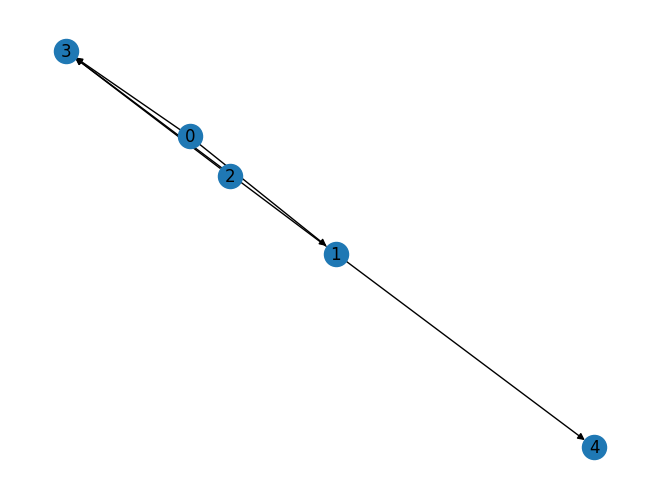

In [50]:
scm.draw()

## Generating synthetic datasets from SCMs

Using the `simulate` method, you can create a synthetic dataframe from the causal generative model. For example, the following will simply simulate an observational data of size $15$ on the produced SCM.

In [51]:
scm.simulate(n_samples = 15)


,0,1,2,3,4
0,0.658389,0.999804,1.388059,1.912156,2.094935
1,1.060816,0.933258,1.845535,3.713308,1.469895
2,1.031251,-0.285353,0.102848,0.929518,1.172063
3,0.670208,0.458970,0.926440,2.445130,1.189367
4,0.606766,0.183437,-0.330233,3.490294,-0.377331
5,0.548684,1.096357,0.236951,2.211903,2.016551
6,0.541461,0.212065,1.413432,2.440665,-0.255594
7,0.834772,0.537400,1.324905,3.408628,1.059657
8,0.444702,1.072404,1.084538,1.921746,1.775966
9,0.736142,0.671904,1.702143,2.112816,-0.732261


You can even do local interventions with the simulate method. However, for that you need to input a generic function following the same scheme as `get_covariate_from_parents`. However, you can also do a hard intervention easily as follows:

In [52]:
# an example of a hard intervention:
scm.simulate(n_samples = 15,
            intervention_node=2,
            intervention_function=lambda inputs, params: 0.5)

,0,1,2,3,4
0,0.453272,1.085559,0.5,3.363002,1.414761
1,0.256531,-0.036413,0.5,1.226118,1.706972
2,0.410299,0.684139,0.5,0.251898,-0.444793
3,1.253089,1.028810,0.5,3.300420,2.230246
4,0.751557,0.860074,0.5,3.137148,1.609775
5,0.454835,1.359382,0.5,2.002236,1.192311
6,0.603064,0.195150,0.5,1.740158,0.286851
7,-0.051177,-0.439145,0.5,3.380672,0.039395
8,0.597159,1.273872,0.5,2.252986,1.989963
9,1.106885,1.490240,0.5,2.810382,1.114129


An example of a soft intervention function where $f_i(z_i, Par(i))$ is altered in a way that the $i$th input is multiplied by $i$ and all of it is added with a bias.

In [53]:
def soft_intervention_function(inputs, params):
    inputs = [x * (i + 1) for i, x in enumerate(inputs)]
    return scm.get_covariate_from_parents(inputs, params) + 5

# an example of a soft intervention:
scm.simulate(n_samples = 15,
            intervention_node=0,
            intervention_function=soft_intervention_function)

,0,1,2,3,4
0,5.721371,-0.265526,1.173957,2.414166,0.377689
1,5.315739,0.531253,0.837869,2.720308,-0.649764
2,5.326641,0.558463,1.112042,4.195801,1.453274
3,5.596318,1.211901,-0.130732,2.007349,0.402839
4,5.646783,0.182502,0.602085,2.715342,2.162280
5,5.468351,0.160167,1.383651,2.757127,-0.051751
6,5.706214,-0.275749,0.836742,2.392413,1.706357
7,5.376239,-0.105105,1.008686,2.492706,-0.260756
8,5.546768,0.960387,1.199481,3.508540,0.496358
9,4.600527,-0.253722,0.999309,2.579978,0.980004
